# Lithographic wells corrugations model

In [65]:
# calcolates simple matrix for mapping clusters colloids into primitive cell and viceversa.
def calc_matrices_square(R):
    area  = R*R
    u     = np.array([[1,0], [0,1]])*R/area
    u_inv = np.array([[1,0], [0,1]])*R
    return u, u_inv

def calc_matrices_triangle(R):
#     area  = R*R*sqrt(3)/2
#     u     = np.array([[1,0], [-1./2, sqrt(3)/2]])*R/area
#     u_inv = np.array([[sqrt(3)/2,0], [1/2,1]])*R
    
    area = R*R*np.sqrt(3)/2.
    u =     np.array([[np.sqrt(3)/2.,0.5], [0,1]])*R/area
    u_inv = np.array([[1,-0.5],[0.0, np.sqrt(3)/2.]])*R
    return u, u_inv

def sub_en(pos, a, b, ww, epsilon, u, u_inv):
    en = np.zeros(pos.shape[0])
    # map to substrate cell
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    # energy inside flat bottom region
    en[R <= a] = -epsilon
    # colloids inside the curve region
    # mask and relative R
    inside = np.logical_and(R<b, R>a)
    Xin = X[inside]
    Yin = Y[inside]
    Rin = R[inside]
    # calculation of energy and force
    # See X. Cao Phys. Rev. E 103, 1 (2021)
    xx = (Rin-a)/(b-a) # Reduce coordinate rho in [0,1]
    # energy
    en[inside] = epsilon/2.*(np.tanh((xx-ww)/xx/(1-xx))-1.)
    return en

def sub_force(pos, a, b, ww, epsilon, u, u_inv):
    Fx = np.zeros(pos.shape[0])
    Fy = np.zeros(pos.shape[0])
    # map to substrate cell
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    # colloids inside the curve region
    # mask and relative R
    inside = np.logical_and(R<b, R>a)
    Xin = X[inside]
    Yin = Y[inside]
    Rin = R[inside]
    # calculation of energy and force
    # See X. Cao Phys. Rev. E 103, 1 (2021)
    xx = (Rin-a)/(b-a) # Reduce coordinate rho in [0,1]
    # force F = - grad(E)
    ff = (xx-ww)/xx/(1-xx)
#     ass = (np.cosh(ff)*(xx-1)*xx)*(np.cosh(ff)*(xx-1)*xx)
    ass = (np.cosh(ff)*(1-xx)*xx)*(np.cosh(ff)*(1-xx)*xx)
    vecF = -epsilon/2*(xx*xx+ww-2*ww*xx)/ass
    # Go from rho to r again, no?
    vecF /= (b-a)
    # AS to EP: Why multiply for x/r?
    Fx[inside] = vecF*Xin/Rin
    Fy[inside] = vecF*Yin/Rin
    return Fx, Fy

def rotate(pos, angle):
    """rotates pos vector (the first two rows are X,Y) by an angle in degrees"""
    for i in range(pos.shape[0]):
        newx = pos[i,0] * np.cos(angle/180*np.pi) - pos[i,1] * np.sin(angle/180*np.pi)
        newy = pos[i,0] * np.sin(angle/180*np.pi) + pos[i,1] * np.cos(angle/180*np.pi)
        pos[i,0] = newx
        pos[i,1] = newy
    return pos

In [66]:
# R, a, b = 5, 0.6, 2
R, a, b = 4.45, 0.6, 2
epsilon, wd = 105, 0.29
# u, u_inv = calc_matrices_square(R)
u, u_inv = calc_matrices_triangle(R)

print(u)
print(u_inv)
print(np.linalg.inv(u))
inputs = [a, b, wd, epsilon, u, u_inv]

side, dens = 5.2, 500
xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
pos = np.array([[x,y] for x in xx for y in yy])
print(xx.shape, pos.shape)

[[0.2247191  0.12974163]
 [0.         0.25948327]]
[[ 4.45       -2.225     ]
 [ 0.          3.85381305]]
[[ 4.45       -2.225     ]
 [ 0.          3.85381305]]
(500,) (250000, 2)


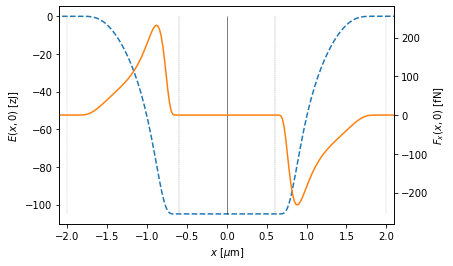

In [67]:
xline = np.array([[x,0] for x in xx])

plt.plot(xline[:,0], sub_en(xline, *inputs), '--')
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$E(x, 0)$ [zJ]")

axt = plt.gca().twinx()
Fx, Fy = sub_force(xline, *inputs)

axt.plot(xline[:,0], Fx, '-', color='tab:orange')
axt.set_ylabel(r"$F_x(x, 0)$ [fN]")

plt.xlim([-2.1,2.1])
xlim = plt.xlim()
ylim = plt.ylim()
plt.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
plt.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.xlim(xlim)

plt.show()

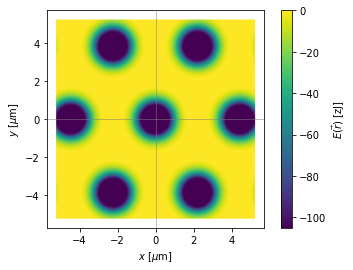

In [68]:
sc = plt.scatter(pos[:,0], pos[:,1], c=sub_en(pos, *inputs), s=0.05)
cbar = plt.colorbar(sc)
cbar.set_label(r'$E(\vec{r})$ [zJ]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')

On R 4.45


/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in cosh
/Users/andreasilva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply


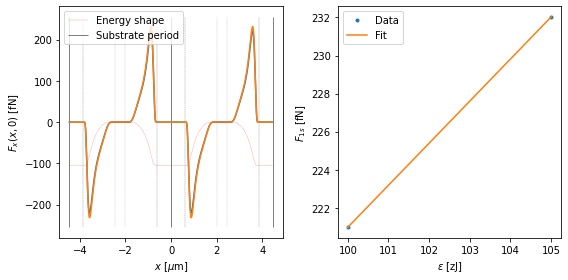

Slope 2.20978
Xmin= 3.57 ± 0.00
-----------------------------------------


In [69]:
R_list = np.array([4.45])
eps_list = np.array([100,105])

# R_list = np.array([4.45])
F_max = np.zeros(R_list.shape)
for i, R in enumerate(R_list):
    print("On R", R)
#     eps_list = np.linspace(1, 2, 10)
    F_max = np.zeros(eps_list.shape)
    xF_max = np.zeros(eps_list.shape)
    u, u_inv = calc_matrices_triangle(R)
    
    fig, (ax_f, ax_scaling) = plt.subplots(1,2, figsize=(8,4))
    
    for ei, epsilon in enumerate(eps_list):
#         print("Epsilon", epsilon)
        inputs = [a, b, wd, epsilon, u, u_inv]

        side, dens = R, 2000
        xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
        xline = np.array([[x,0] for x in xx])
        
        Fx, Fy = sub_force(xline, *inputs)
        F_max[ei] = np.max(Fx)
        xF_max[ei] = xline[np.argmax(Fx)][0]
        ax_f.plot(xline[:,0], Fx, '-',)
    
    Fx, Fy = sub_force(xline, *inputs)
    ax_f.plot(xline[:,0], sub_en(xline, *inputs), ':', color="red", lw=0.4, label="Energy shape")
    ax_f.set_ylabel(r"$F_x(x, 0)$ [fN]")
    ax_f.set_xlabel(r"$x$ [$\mu$m]")

    # Highlight substrate periodicity
    xlim = ax_f.get_xlim()
    ylim = ax_f.get_ylim()
    ax_f.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
    ax_f.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.set_xlim(xlim)
    ax_f.legend()

    ax_scaling.plot(eps_list, F_max, '.', label='Data')
    # plt.gca().set_aspect('equal')

    from numpy.polynomial import polynomial as P
    c = P.polyfit(eps_list,F_max,1)
    cpoly = np.poly1d(c)
    ax_scaling.plot(eps_list, c[1]*eps_list, '-', label='Fit')
    ax_scaling.set_xlabel(r"$\epsilon$ [zJ]")
    ax_scaling.set_ylabel(r"$F_{1s}$ [fN]")
    ax_scaling.legend()
    
    plt.tight_layout()
    plt.show()

#     plt.plot(eps_list, xF_max, ':')
    print("Slope %.5f" % c[1])
    print("Xmin= %.2f ± %.2f" % (np.mean(xF_max),np.std(xF_max)))
#     plt.show()
    print('-----------------------------------------')

So $F_{1s} = c \epsilon$, which is the solution in the reduce coordinates of the Cosh trascendental equation. Varies with $w_d$ of course.

For the whole commensurate cluster, multiply by the number of colloids:

In [70]:
c[1], F_max

(2.209776818066442, array([220.97768181, 232.0265659 ]))

In [72]:
N = 7
for N in [7, 15, 19, 43, 271, 3571]:
    for eps in [105]:
        print(F_max*N)
        print("Cluster N=%i Sub eps=%.f -> F1s=%.4f fN (on single F1s/N=%.4f)" % (N, eps, eps*N*c[1], eps*c[1]))

[1546.84377265 1624.18596128]
Cluster N=7 Sub eps=105 -> F1s=1624.1860 fN (on single F1s/N=232.0266)
[3314.6652271  3480.39848845]
Cluster N=15 Sub eps=105 -> F1s=3480.3985 fN (on single F1s/N=232.0266)
[4198.57595433 4408.50475204]
Cluster N=19 Sub eps=105 -> F1s=4408.5048 fN (on single F1s/N=232.0266)
[9502.04031769 9977.14233357]
Cluster N=43 Sub eps=105 -> F1s=9977.1423 fN (on single F1s/N=232.0266)
[59884.9517696  62879.19935808]
Cluster N=271 Sub eps=105 -> F1s=62879.1994 fN (on single F1s/N=232.0266)
[789111.30173152 828566.8668181 ]
Cluster N=3571 Sub eps=105 -> F1s=828566.8668 fN (on single F1s/N=232.0266)


## Gaussian model



In [56]:
R, sigma = 4.45, 0.5
epsilon = 1
u, u_inv = calc_matrices_square(R)
# u, u_inv = calc_matrices_triangle(R)

print(u)
print(u_inv)
print(np.linalg.inv(u))

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.square(sig)))



[[0.2247191 0.       ]
 [0.        0.2247191]]
[[4.45 0.  ]
 [0.   4.45]]
[[4.45 0.  ]
 [0.   4.45]]


In [57]:
def en_gaussian(pos, sigma, epsilon, u, u_inv):
    from numpy.linalg import norm as npnorm
    en = np.zeros(pos.shape[0])
    posp = np.dot(u, pos.T).T
    posp -= np.floor(posp + 0.5)
    pospp = np.dot(u_inv, posp.T).T
    posR = npnorm(pospp, axis=1)
    en = -epsilon*gaussian(posR, 0, sigma)
    
    return en

def F_T_gaussian(pos, sigma, epsilon, u, u_inv):
    from numpy.linalg import norm as npnorm
    F = np.zeros(shape=(pos.shape[0],2))
    posp = np.dot(u, pos.T).T
    posp -= np.floor(posp + 0.5)
    pospp = np.dot(u_inv, posp.T).T
    posR = npnorm(pospp, axis=1)
    off = posR != 0
    F[off, 0] = -epsilon*gaussian(posR[off],0,sigma) * (posR[off] / np.power(sigma, 2.)) * pospp[off,0] / posR[off]
    F[off, 1] = -epsilon*gaussian(posR[off],0,sigma) * (posR[off] / np.power(sigma, 2.)) * pospp[off,1] / posR[off]
    tau = np.cross(pos, F)
    return F, tau

inputs = [sigma, epsilon, u, u_inv]

## Cutoff gaussian!

In [38]:
def en_gaussian(pos, sigma, a, b, epsilon, u, u_inv):
    from numpy.linalg import norm as npnorm
    en = np.zeros(pos.shape[0])
    posp = np.dot(u, pos.T).T
    posp -= np.floor(posp + 0.5)
    pospp = np.dot(u_inv, posp.T).T
    posR = npnorm(pospp, axis=1)
    tail = np.logical_and(posR>a, posR<b)
    inside = posR<=a
    print("Inside %i tail %i. Tot %i" % (len(posR[inside]), len(posR[tail]), len(posR)))
    en[inside] = -epsilon*gaussian(posR[inside], 0, sigma)
    Rtail = posR[tail]
    # calculation of energy and force
    ftail = 1 - (Rtail-a)/(b-a) # Damping [1,0]
    en[tail] = -epsilon*gaussian(Rtail, 0, sigma)*ftail
    return en

def F_T_gaussian(pos, sigma, a, b, epsilon, u, u_inv):
    from numpy.linalg import norm as npnorm
    F = np.zeros(shape=(pos.shape[0],2))
    posp = np.dot(u, pos.T).T
    posp -= np.floor(posp + 0.5)
    pospp = np.dot(u_inv, posp.T).T
    posR = npnorm(pospp, axis=1)
    
    tail = np.logical_and(posR>a, posR<b)
    inside = np.logical_and(posR<=a, posR != 0)
    F[inside, 0] = -epsilon*gaussian(posR[inside],0,sigma) * (posR[inside] / np.power(sigma, 2.)) * pospp[inside,0] / posR[inside]
    F[inside, 1] = -epsilon*gaussian(posR[inside],0,sigma) * (posR[inside] / np.power(sigma, 2.)) * pospp[inside,1] / posR[inside]
    Rtail = posR[tail]
    # calculation of energy and force
    ftail = 1 - (Rtail-a)/(b-a) # Damping [1,0]
    F[tail, 0] = -ftail*epsilon*gaussian(Rtail,0,sigma) * (Rtail / np.power(sigma, 2.)) * pospp[tail,0] / posR[tail]
    F[tail, 1] = -ftail*epsilon*gaussian(Rtail,0,sigma) * (Rtail / np.power(sigma, 2.)) * pospp[tail,1] / posR[tail]
    tau = np.cross(pos, F)
    return F, tau

a, b = 2.0, 2.2
inputs = [sigma, a, b, epsilon, u, u_inv]
print(inputs)

[0.5, 2.0, 2.2, 1, array([[0.2247191, 0.       ],
       [0.       , 0.2247191]]), array([[4.45, 0.  ],
       [0.  , 4.45]])]


In [58]:
side, dens = 5.2, 500
xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
pos = np.array([[x,y] for x in xx for y in yy])
print(xx.shape, pos.shape)

(500,) (250000, 2)


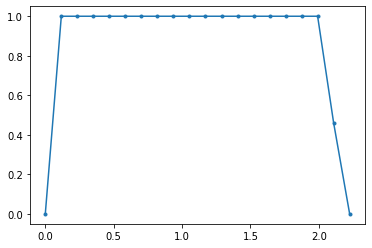

NameError: name 'ftail' is not defined

In [42]:
xline = np.linspace(0,R/2,20, endpoint=True)
inside = np.logical_and(xline<=a, xline != 0)
tail = np.logical_and(xline>a, xline<b)

xtail = xline[tail]
f = np.zeros(xline.shape[0])
f[inside] = 1
f[tail] = 1-(xtail-a)/(b-a) # Reduce coordinate rho in [1,0]

plt.plot(xline, f, '.-')
plt.show()
xtail[0], ftail[0], ftail[-1]

xxline = np.array([[x,0] for x in xline])

plt.plot(xxline[:,0], en_gaussian(xxline, *inputs), '.-')

En across 2 p/m 1e-05 point Ep=-0.00034 Em=-0.00034 deltaE=-5.4e-08
Fx across 2 p/m 1e-05 point Fp=-0.0027 Fm=-0.0027 deltaF=4e-07


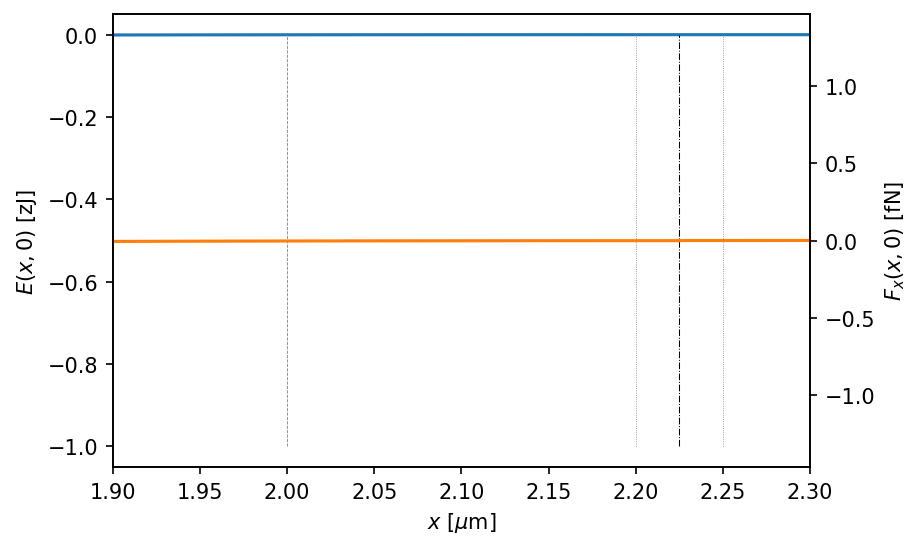

In [59]:
from numpy import array as npa
xline = np.linspace(-R, R, 2000, endpoint=True)
xline = np.array([[x,0] for x in xline])
# inputs = [sigma, epsilon, u, u_inv]


delta = 1e-5
xc = a
xp, xm = npa([[xc+delta,0]]), npa([[xc-delta,0]])
en_minus, en_plus = en_gaussian(xp, *inputs), en_gaussian(xm, *inputs)
(F_minus, _), (F_plus, _) = F_T_gaussian(xm, *inputs), F_T_gaussian(xp, *inputs)
print("En across %.4g p/m %.4g point Ep=%.2g Em=%.2g deltaE=%.2g" % (xc, delta, en_plus, en_minus, en_plus-en_minus))
print("Fx across %.4g p/m %.4g point Fp=%.2g Fm=%.2g deltaF=%.2g" % (xc, delta, F_plus[0,0], F_minus[0,0], F_plus[0,0]-F_minus[0,0]))

# a, b = 2*sigma, 4*sigma

plt.plot(xline[:,0], en_gaussian(xline, *inputs), '-')
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$E(x, 0)$ [zJ]")

axt = plt.gca().twinx()
F, _ = F_T_gaussian(xline, *inputs)

axt.plot(xline[:,0], F[:,0], '-', color='tab:orange')
axt.set_ylabel(r"$F_x(x, 0)$ [fN]")

plt.xlim([R/2-0.5,R/2+0.5])
plt.xlim([a-0.1,R-b+0.5])
plt.xlim([a-0.1,b+0.1])
# plt.xlim([0,R/2+0.5])
# plt.xlim([-R,R])
xlim = plt.xlim()
ylim = plt.ylim()
plt.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
plt.vlines([n*R/2 for n in np.arange(-5,5,1)], *ylim, ls="-.", lw=0.5, color='black')
plt.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.xlim(xlim)

plt.gcf().set_dpi(150)
plt.show()

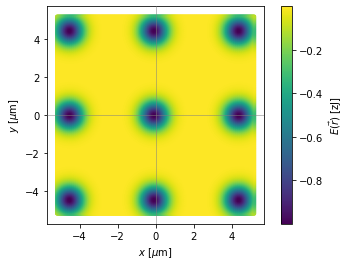

In [60]:
sc = plt.scatter(pos[:,0], pos[:,1], c=en_gaussian(pos, *inputs), s=5)
cbar = plt.colorbar(sc)
cbar.set_label(r'$E(\vec{r})$ [zJ]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')

On R 4.0


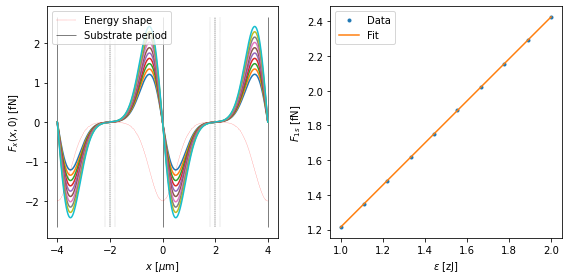

Slope 1.21306
Xmin= 3.50 ± 0.00
-----------------------------------------
On R 4.666666666666667


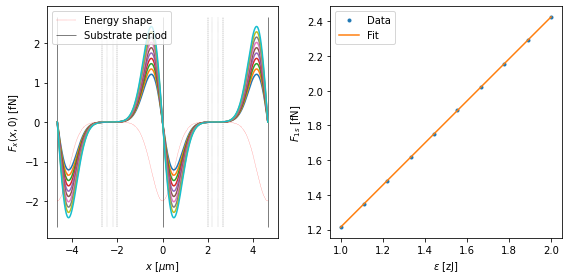

Slope 1.21306
Xmin= 4.17 ± 0.00
-----------------------------------------
On R 5.333333333333333


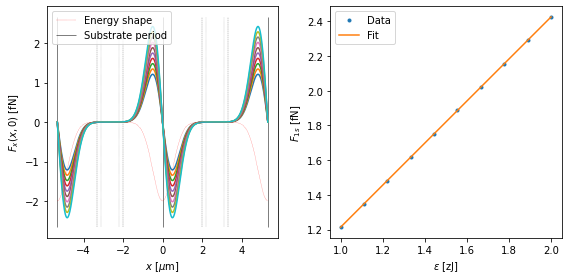

Slope 1.21306
Xmin= -0.50 ± 0.00
-----------------------------------------
On R 6.0


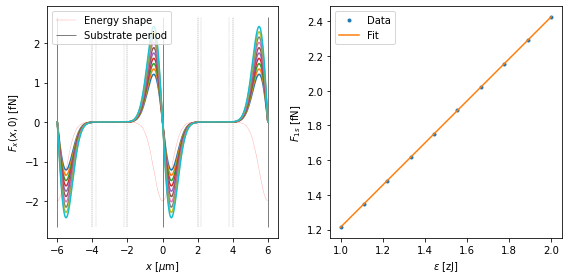

Slope 1.21305
Xmin= -0.50 ± 0.00
-----------------------------------------


In [61]:
R_list = np.linspace(4, 6, 4)
# R_list = np.array([4.45])
F_max = np.zeros(R_list.shape)

for i, R in enumerate(R_list):
    print("On R", R)
    eps_list = np.linspace(1, 2, 10)
    F_max = np.zeros(eps_list.shape)
    xF_max = np.zeros(eps_list.shape)
    u, u_inv = calc_matrices_triangle(R)
    
    fig, (ax_f, ax_scaling) = plt.subplots(1,2, figsize=(8,4))
    
    for ei, epsilon in enumerate(eps_list):
#         print("Epsilon", epsilon)
        inputs = [sigma, epsilon, u, u_inv]

        side, dens = R, 2000
        xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
        xline = np.array([[x,0] for x in xx])
        
        F, _ = F_T_gaussian(xline, *inputs)
        Fx, Fy = F[:,0], F[:,1]

        F_max[ei] = np.max(Fx)
        xF_max[ei] = xline[np.argmax(Fx)][0]
        ax_f.plot(xline[:,0], Fx, '-',)
    
    F, _ = F_T_gaussian(xline, *inputs)
    Fx, Fy = F[:,0], F[:,1]
    ax_f.plot(xline[:,0], en_gaussian(xline, *inputs), ':', color="red", lw=0.4, label="Energy shape")
    ax_f.set_ylabel(r"$F_x(x, 0)$ [fN]")
    ax_f.set_xlabel(r"$x$ [$\mu$m]")

    # Highlight substrate periodicity
    xlim = ax_f.get_xlim()
    ylim = ax_f.get_ylim()
    ax_f.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
    ax_f.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
    ax_f.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
    ax_f.set_xlim(xlim)
    ax_f.legend()

    ax_scaling.plot(eps_list, F_max, '.', label='Data')
    # plt.gca().set_aspect('equal')

    from numpy.polynomial import polynomial as P
    c = P.polyfit(eps_list,F_max,1)
    cpoly = np.poly1d(c)
    ax_scaling.plot(eps_list, c[1]*eps_list, '-', label='Fit')
    ax_scaling.set_xlabel(r"$\epsilon$ [zJ]")
    ax_scaling.set_ylabel(r"$F_{1s}$ [fN]")
    ax_scaling.legend()
    
    plt.tight_layout()
    plt.show()

#     plt.plot(eps_list, xF_max, ':')
    print("Slope %.5f" % c[1])
    print("Xmin= %.2f ± %.2f" % (np.mean(xF_max),np.std(xF_max)))
#     plt.show()
    print('-----------------------------------------')

In [62]:
print("Constant", c[1])
for N in [19, 37, 91, 271, 1141, 3571]:
    for eps in [105]:
#         print(F_max*N)
        print("Cluster N=%i Sub eps=%.f -> F1s=%.4g fN (on single F1s/N=%.5g)" % (N, eps, eps*N*c[1], eps*c[1]))

Constant 1.2130537365440661
Cluster N=19 Sub eps=105 -> F1s=2420 fN (on single F1s/N=127.37)
Cluster N=37 Sub eps=105 -> F1s=4713 fN (on single F1s/N=127.37)
Cluster N=91 Sub eps=105 -> F1s=1.159e+04 fN (on single F1s/N=127.37)
Cluster N=271 Sub eps=105 -> F1s=3.452e+04 fN (on single F1s/N=127.37)
Cluster N=1141 Sub eps=105 -> F1s=1.453e+05 fN (on single F1s/N=127.37)
Cluster N=3571 Sub eps=105 -> F1s=4.548e+05 fN (on single F1s/N=127.37)


So $F_{1s} = 0.4469089281335388 \epsilon$, which is the solution in the reduce coordinates of the Cosh trascendental equation. Varies with $w_d$ of course.

For the whole commensurate cluster, multiply by the number of colloids:

In [ ]:
N = 7
for eps in eps_list:
    print("Cluster N=%i Sub eps=%.3f -> F1s=%.4f fN (on single F1s/N=%.4f)" % (N, eps, eps*N*c[1], eps*c[1]))

In [ ]:
R, sigma = 4.45*sqrt(7)/2, 0.5
epsilon = 1
# u, u_inv = calc_matrices_square(R)
u, u_inv = calc_matrices_triangle(R)


xline = np.array([[x,0] for x in xx])

a, b = 2*sigma, 4*sigma

plt.plot(xline[:,0], en_gaussian(xline, *inputs), '--')
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$E(x, 0)$ [zJ]")


axt = plt.gca().twinx()
Fx, Fy = F_gaussian(xline, *inputs)

axt.plot(xline[:,0], Fx, '-', color='tab:orange')
axt.set_ylabel(r"$F_x(x, 0)$ [fN]")

plt.xlim([-2.1,2.1])
xlim = plt.xlim()
ylim = plt.ylim()
plt.vlines([n*R for n in np.arange(-5,5,1)], *ylim, label="Substrate period", ls="-", lw=0.5, color='black')
plt.vlines([n*R+a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R-a for n in np.arange(-5,5,1)], *ylim, ls="--", lw=0.4, color='gray')
plt.vlines([n*R+b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.vlines([n*R-b for n in np.arange(-5,5,1)], *ylim, ls=":", lw=0.4, color='gray')
plt.xlim(xlim)

plt.show()

print(u)
print(u_inv)
print(np.linalg.inv(u))
inputs = [sigma, epsilon, u, u_inv]

side, dens = 5.2, 15
xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
pos = np.array([[x,y] for x in xx for y in yy])
Fx, Fy = F_gaussian(pos, *inputs)

print(xx.shape, pos.shape)

sc = plt.scatter(pos[:,0], pos[:,1], c=en_gaussian(pos, *inputs), s=5)
qv = plt.quiver(pos[:,0], pos[:,1], Fx, Fy,
                units='xy', angles='xy', scale_units='xy', scale=0.5)

cbar = plt.colorbar(sc)
cbar.set_label(r'$E(\vec{r})$ [zJ]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')
plt.gcf().set_dpi(200)

In [ ]:
def F_T_gaussian(pos, sigma, epsilon, u, u_inv):
    Fx = np.zeros(pos.shape[0])
    Fy = np.zeros(pos.shape[0])
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    off = R != 0
    Fx[off] = epsilon*gaussian(R[off],0,sigma) * (R[off] / np.power(sigma, 2.)) * X[off] / R[off]
    Fy[off] = epsilon*gaussian(R[off],0,sigma) * (R[off] / np.power(sigma, 2.)) * Y[off] / R[off]
    return [Fx, Fy]

F = np.array([Fx,Fy]).T
print(pos.shape, Fx.shape, Fy.shape)

tau = np.cross(pos, F)
tau.shape, sum(tau)

In [ ]:
sc = plt.scatter(pos[:,0], pos[:,1], c=tau, cmap='RdBu', s=15)
qv = plt.quiver(pos[:,0], pos[:,1], Fx, Fy,
                units='xy', angles='xy', scale_units='xy', scale=0.5)

cbar = plt.colorbar(sc)
cbar.set_label(r'$\tau(\vec{r})$ [fN$\cdot\mu$m]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')
plt.gcf().set_dpi(200)

In [ ]:
dtheta=0.01
en_plus = en_gaussian(rotate(pos, dtheta),  *inputs)
en_minus = en_gaussian(rotate(pos,-dtheta),  *inputs)
# add external torque
torque = -(en_plus - en_minus)/dtheta/2
print(torque.shape)
sc = plt.scatter(pos[:,0], pos[:,1], c=torque, cmap='RdBu', s=15)

cbar = plt.colorbar(sc)
cbar.set_label(r'$\tau(\vec{r})$ [fN$\cdot\mu$m]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')
plt.gcf().set_dpi(200)

In [ ]:
tau_ratio = tau/torque
mask_nan = np.isfinite(tau_ratio)
plt.plot(range(tau_ratio[mask_nan].shape[0]), tau_ratio[mask_nan])
plt.show()

In [ ]:
s_tau, s_toruqe = np.sign(tau), np.sign(torque)

sc = plt.scatter(pos[:,0], pos[:,1], c=(s_tau-s_toruqe), cmap='RdBu', s=15)

cbar = plt.colorbar(sc)
cbar.set_label(r'sign')

sc = plt.scatter(pos[tau==0,0], pos[tau==0,1], ec='black', marker='s', lw=0.5, fc='none', s=40)
sc = plt.scatter(pos[torque==0,0], pos[torque==0,1], ec='black', marker='h', lw=0.5, fc='none', s=100)

plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')
plt.gcf().set_dpi(200)




In [ ]:
s_tau, s_toruqe
s_tau - s_toruqe

In [ ]:
pos_cl.shape, np.linalg.norm(pos_cl, axis=1).shape

In [ ]:
from tool_create_circles import create_cluster_circle
from tool_create_hexagons import create_cluster_hex
from tempfile import NamedTemporaryFile
def cluster_inhex_Nl(N1, N2,  a1 = np.array([4.45, 0]), a2 = np.array([-4.45/2, 4.45*np.sqrt(3)/2]),
                     clgeom_fname = "input_pos.hex", cluster_f = create_cluster_circle):
    """Create input file in EP hex format for a cluster of Bravais size Nl"""

    clgeom_file = open(clgeom_fname, 'w') # Store it somewhere for MD function
    with NamedTemporaryFile(prefix=clgeom_fname, suffix='tmp', delete=True) as tmp: # write input on tempfile
        tmp.write(bytes("%i %i\n" % (N1, N2), encoding = 'utf-8'))
        tmp.write(bytes("%15.10g %15.10g\n" % (a1[0], a1[1]), encoding = 'utf-8'))
        tmp.write(bytes("%15.10g %15.10g\n" % (a2[0], a2[1]), encoding = 'utf-8'))
        tmp.seek(0) # Reset 'reading needle'
        pos = cluster_f(tmp.name, clgeom_file)[:,:2] # Pass name of tempfile to create function
    clgeom_file.close() # Close file so MD function can read it

    return pos, clgeom_fname
Nl = 5
pos_cl, _ = cluster_inhex_Nl(Nl, Nl, cluster_f=create_cluster_hex)
N = pos_cl.shape[0]
print("N=", N)
angle=0
tmp_pos = pos_cl.copy()
pos_cl = rotate(pos_cl, angle)
plt.scatter(pos_cl[:,0], pos_cl[:,1])
plt.gca().set_aspect('equal')
plt.show()
# def rotate(pos, angle):
#     """rotates pos vector (the first two rows are X,Y) by an angle in degrees"""
#     for i in range(pos.shape[0]):
#         newx = pos[i,0] * np.cos(angle/180*np.pi) - pos[i,1] * np.sin(angle/180*np.pi)
#         newy = pos[i,0] * np.sin(angle/180*np.pi) + pos[i,1] * np.cos(angle/180*np.pi)
#         pos[i,0] = newx
#         pos[i,1] = newy
#     return pos

rot_mtr = np.array([[np.cos(angle/180*np.pi), -np.sin(angle/180*np.pi)],[np.sin(angle/180*np.pi), np.cos(angle/180*np.pi)]])
print(tmp_pos.shape, rot_mtr.shape)
tmp_rotpos = np.dot(rot_mtr, tmp_pos.T).T
print(tmp_rotpos.shape)
plt.scatter(tmp_rotpos[:,0], tmp_rotpos[:,1])
plt.gca().set_aspect('equal')
plt.show()
print(np.any((pos_cl-tmp_rotpos)>1e-10))

In [ ]:
R, sigma = 4.45*np.sqrt(7)/2, 0.6
# R, sigma = 5, 0.6
R, sigma = 4.45, 0.6
epsilon = 1
# u, u_inv = calc_matrices_square(R)
u, u_inv = calc_matrices_triangle(R)

inputs = [sigma, epsilon, u, u_inv]

print(u)
print(u_inv)
print(np.linalg.inv(u))
inputs = [sigma, epsilon, u, u_inv]

side, dens = np.max(pos_cl), 300
xx, yy = np.linspace(-side, side, dens), np.linspace(-side, side, dens)
pos = np.array([[x,y] for x in xx for y in yy])
print(xx.shape, pos.shape)

sc = plt.scatter(pos[:,0], pos[:,1], c=en_gaussian(pos, *inputs), 
                 cmap='binary_r', ec='none', zorder=-10, alpha=0.7, s=0.1)
print("en", sum(en_gaussian(pos, *inputs)))
sc = plt.scatter(pos_cl[:,0], pos_cl[:,1], c=en_gaussian(pos_cl, *inputs), s=50)
cbar = plt.colorbar(sc)
cbar.set_label(r'$E(\vec{r})$ [zJ]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')
plt.gcf().set_dpi(200)
plt.show()

F, tau = F_T_gaussian(pos_cl, *inputs)
sc = plt.scatter(pos_cl[:,0], pos_cl[:,1], c=tau, cmap='RdBu', s=50)
qv = plt.quiver(pos_cl[:,0], pos_cl[:,1], F[:,0], F[:,1],
                angles='xy', units='xy', scale_units='xy', scale=0.05
               )
Fcm, Tcm = np.sum(F, axis=0), np.sum(tau)
print(Fcm.shape, Tcm.shape)
print(Fcm, Tcm)
dtheta=0.01
en_plus = np.sum(en_gaussian(rotate(pos_cl, dtheta), *inputs))
en_minus = np.sum(en_gaussian(rotate(pos_cl, -dtheta),  *inputs))
# add external torque
torque = -(en_plus - en_minus)/dtheta/2

print("Fin diff ", torque)
cbar = plt.colorbar(sc)
cbar.set_label(r'$\tau(\vec{r})$ [fN$\cdot\mu$m]')
plt.axhline(zorder=4, color="gray", lw=0.5)
plt.axvline(zorder=4, color="gray", lw=0.5)
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$y$ [$\mu$m]")
plt.gca().set_aspect('equal')
plt.gcf().set_dpi(200)

In [ ]:
def sub_force_tau0(pos, a, b, ww, epsilon, u, u_inv):
    Fx = np.zeros(pos.shape[0])
    Fy = np.zeros(pos.shape[0])
    # map to substrate cell
    Xp = pos[:,0]*u[0,0] + pos[:,1]*u[0,1]
    Yp = pos[:,0]*u[1,0] + pos[:,1]*u[1,1]
    Xp -= np.floor(Xp + 0.5)
    Yp -= np.floor(Yp + 0.5)
    X = Xp*u_inv[0, 0] + Yp*u_inv[0, 1]
    Y = Xp*u_inv[1, 0] + Yp*u_inv[1, 1]
    R  = np.sqrt(X*X+Y*Y)
    # colloids inside the curve region
    # mask and relative R
    inside = np.logical_and(R<b, R>a)
    Xin = X[inside]
    Yin = Y[inside]
    Rin = R[inside]
    # calculation of energy and force
    # See X. Cao Phys. Rev. E 103, 1 (2021)
    xx = (Rin-a)/(b-a) # Reduce coordinate rho in [0,1]
    # force F = - grad(E)
    ff = (xx-ww)/xx/(1-xx)
#     ass = (np.cosh(ff)*(xx-1)*xx)*(np.cosh(ff)*(xx-1)*xx)
    ass = (np.cosh(ff)*(1-xx)*xx)*(np.cosh(ff)*(1-xx)*xx)
    vecF = -epsilon/2*(xx*xx+ww-2*ww*xx)/ass
    # Go from rho to r again, no?
    vecF /= (b-a)
    # AS to EP: Why multiply for x/r?
    Fx[inside] = vecF*Xin/Rin
    Fy[inside] = vecF*Yin/Rin
    tau = np.cross(pos, np.array([Fx,Fy]).T)
    return np.array([Fx,Fy]).T, tau

def sub_force_tau(pos, a, b, ww, epsilon, u, u_inv):
    from numpy.linalg import norm as npnorm
    F = np.zeros(shape=(pos.shape[0],2))
    # map to substrate cell
    posp = np.dot(u, pos.T).T
    posp -= np.floor(posp + 0.5)
    # back to real space
    pospp = np.dot(u_inv, posp.T).T
    posR = npnorm(pospp, axis=1)
    # colloids inside the curve region
    # mask and relative R
    inside = np.logical_and(posR<b, posR>a)
#     Xin = X[inside]
#     Yin = Y[inside]
    Rin = posR[inside]
    # calculation of energy and force
    # See X. Cao Phys. Rev. E 103, 1 (2021)
    xx = (Rin-a)/(b-a) # Reduce coordinate rho in [0,1]
    # force F = - grad(E)
    ff = (xx-ww)/xx/(1-xx)
#     ass = (np.cosh(ff)*(xx-1)*xx)*(np.cosh(ff)*(xx-1)*xx)
    ass = (np.cosh(ff)*(1-xx)*xx)*(np.cosh(ff)*(1-xx)*xx)
    vecF = -epsilon/2*(xx*xx+ww-2*ww*xx)/ass
    # Go from rho to r again, no?
    vecF /= (b-a)
    F[inside,0] = vecF*pospp[inside,0]/Rin
    F[inside,1] = vecF*pospp[inside,1]/Rin
    tau = np.cross(pos, F)
    return F, tau

inputs = [a, b, wd, epsilon, u, u_inv]
F, tau = sub_force_tau(pos_cl, *inputs)
print(F.shape, tau.shape)
print(np.sum(F, axis=0).shape)

In [ ]:
# R, sigma = 4.45*np.sqrt(7)/2, 0.6
R, sigma = 4.45, 0.6
# R, sigma = 5, 0.6
# u, u_inv = calc_matrices_square(R)
u, u_inv = calc_matrices_triangle(R)
epsilon = 105

inputs = [sigma, epsilon, u, u_inv]
force_f = F_T_gaussian
en_f = en_gaussian
# inputs = [a, b, wd, epsilon, u, u_inv]
# force_f = sub_force_tau0
# en_f = sub_en
print(inputs)

Nl = 5
pos_cl, _ = cluster_inhex_Nl(Nl, Nl, cluster_f=create_cluster_hex)
N = pos_cl.shape[0]
print("N=", N)

th0, th1, dtheta = -60, 60, 0.1
Nsteps = int(np.ceil((th1-th0)/dtheta))
pos_cl = rotate(pos_cl, th0)

th_trj, tau_trj, tauFD_trj = np.zeros(Nsteps), np.zeros(Nsteps), np.zeros(Nsteps)
th = th0
for it in range(Nsteps):
    if (it/Nsteps*100)%10 == 0:
        print("On it %i of %i (%.2f)" % (it, Nsteps, it/Nsteps))
    F, tau = force_f(pos_cl, *inputs)
    Fcm, Tcm = np.sum(F, axis=0), np.sum(tau)

    en_plus = np.sum(en_f(rotate(pos_cl, dtheta), *inputs))
    en_minus = np.sum(en_f(rotate(pos_cl,-dtheta),  *inputs))
    # add external torque
    TcmFD = -(en_plus - en_minus)/dtheta/2
#     print("F", Fcm, "T", Tcm, "Fin diff ", TcmFD)
    
    pos_cl = rotate(pos_cl, dtheta)
    th += dtheta
    th_trj[it] = th
    tau_trj[it], tauFD_trj[it] = Tcm, TcmFD
#     print('-'*50)

In [ ]:
fact = 100
plt.title("N=%i" % N)
plt.plot(th_trj, tauFD_trj*fact, lw=1.0, label=r'finite diff $\times$ %g' % fact)
plt.plot(th_trj, tau_trj,  lw=0.5, label='micro')
plt.vlines([-30,0,30], *plt.ylim(), color='black', lw=0.5)
plt.hlines([min(tau_trj)], *plt.ylim(), color='black', lw=0.5)
print("eps%5.5g min tau %.10g" % (epsilon, min(tau_trj)))
plt.hlines([0], *plt.xlim(), color='black', lw=0.5)
plt.legend()
plt.xlim([-60,60])
plt.gcf().set_dpi(200)
plt.show()

In [ ]:
pos_cm = [0,0]
pos_cl.shape, (pos_cl-pos_cm).shape